# Emotion Classification based on Facial Expression Dataset

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

from mlxtend.plotting import plot_confusion_matrix

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, MaxPool2D
from keras.optimizers import RMSprop, Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

## Importing Dataset

In [1]:
## Importing data

# data = pd.read_csv('data/icml_face_data.csv')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
data = pd.read_csv('/content/drive/MyDrive/icml_face_data.csv')

In [7]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [8]:
data.columns

Index(['emotion', ' Usage', ' pixels'], dtype='object')

## Defining some helper functions

In [9]:
def prepare_data(data):
    """
        Preparing data for modeling 
        input: data frame with labels und pixel data
        output: image and label array 
    """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

In [10]:
def plot_examples(label=0):
    """
        Plotting 5 examples of a particular 
        emotion label
        input: label
        output: images of that label
        
    """
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

In [11]:
def plot_all_emotions():
    """
        Plotting an example of a each emotion
        input: none
        output: images of each label

    """
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

In [12]:
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()

In [13]:
def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

## Overview of the dataset

In [14]:
data[" Usage"].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name:  Usage, dtype: int64

In [15]:
emotions = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy",
            4: "Sad",5: "Surprise", 6: "Neutral" }
emotion_counts = data["emotion"].value_counts(sort=False).reset_index()
emotion_counts.columns = ["emotion", "number"]
emotion_counts["emotion"] = emotion_counts["emotion"].map(emotions)
emotion_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Disgust,547


Text(0.5, 0, 'Emotions')

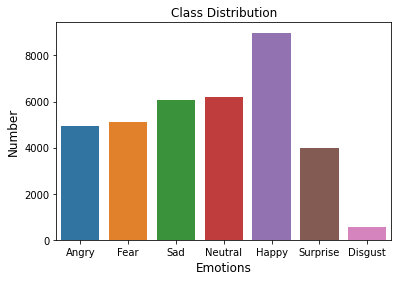

In [16]:
plt.figure(figsize=(6,4))
sns.barplot(x = emotion_counts["emotion"],
            y = emotion_counts["number"])
plt.title("Class Distribution")
plt.ylabel("Number", fontsize=12)
plt.xlabel("Emotions", fontsize=12)

# Pre-processing data

### Converting strings to list of integers and reshaping the image

In [18]:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])

val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])

test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

### Normalize grayscale image with 255

In [19]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255

val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255

test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

### Converting the class vector (integers) to binary class matrix.

In [20]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

## Plotting all the types of emotion(label) in the dataset

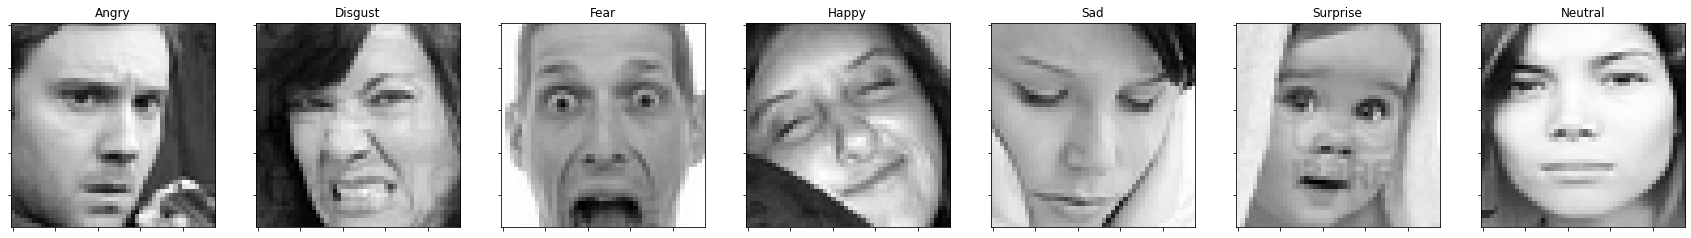

In [21]:
plot_all_emotions()

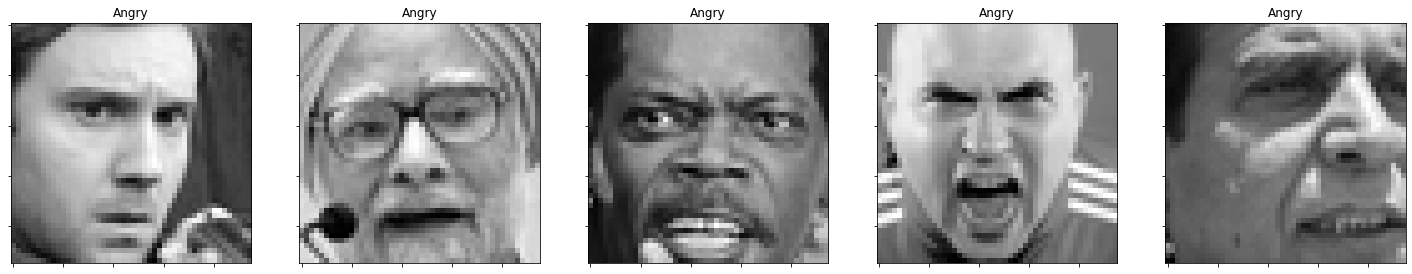

In [22]:
plot_examples(label=0)

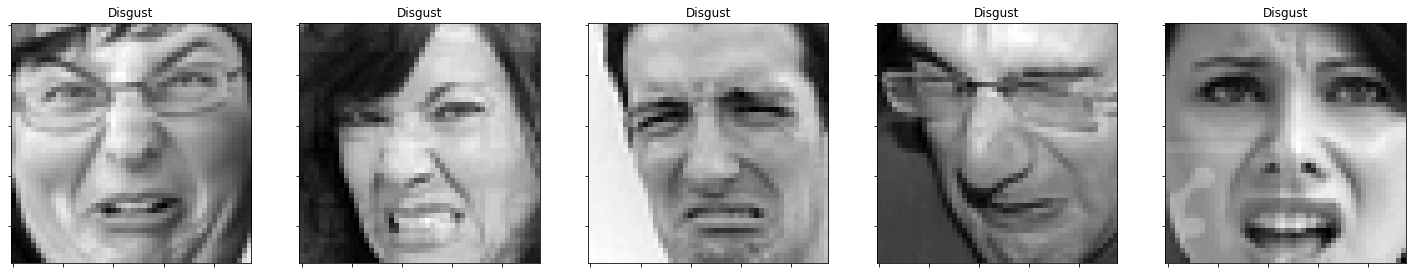

In [23]:
plot_examples(label=1)

## Comparing the data distribution between test labels and validation labels

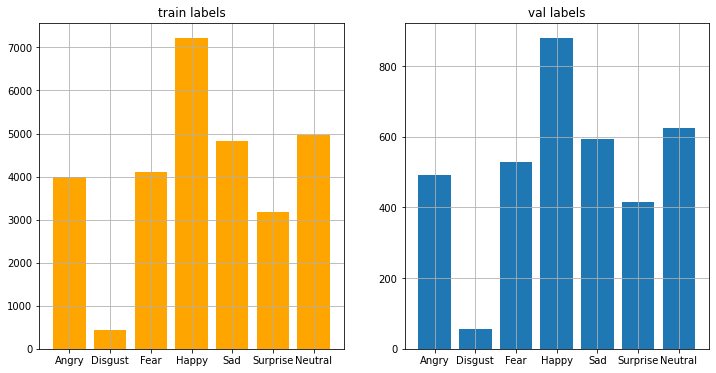

In [24]:
plot_compare_distributions(train_labels,val_labels, title1="train labels", title2="val labels")

In [25]:
class_weight = dict(zip(range(0, 7), (((data[data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data[' Usage']=='Training']['emotion'])).tolist()))

In [26]:
class_weight

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

# Making the deep model

In [27]:
model = Sequential()

#Layer 1
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.2))

#Layer 2
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.2))

#Layer 3
model.add(Conv2D(512, (3, 3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.2))

#Layer 4
model.add(Conv2D(512, (3, 3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))


In [28]:
model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 21, 21, 128)      5

In [31]:
history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    class_weight = class_weight,
                    epochs=8,
                    batch_size=256)

Epoch 1/8
113/113 [==============================] - 10s 80ms/step - loss: 0.1298 - accuracy: 0.6792 - val_loss: 1.1896 - val_accuracy: 0.5726
Epoch 2/8
113/113 [==============================] - 9s 76ms/step - loss: 0.1140 - accuracy: 0.7179 - val_loss: 1.1155 - val_accuracy: 0.6138
Epoch 3/8
113/113 [==============================] - 9s 77ms/step - loss: 0.1036 - accuracy: 0.7434 - val_loss: 1.1535 - val_accuracy: 0.6077
Epoch 4/8
113/113 [==============================] - 9s 80ms/step - loss: 0.0952 - accuracy: 0.7630 - val_loss: 1.3030 - val_accuracy: 0.5676
Epoch 5/8
113/113 [==============================] - 9s 80ms/step - loss: 0.0882 - accuracy: 0.7803 - val_loss: 1.2576 - val_accuracy: 0.5940
Epoch 6/8
113/113 [==============================] - 9s 81ms/step - loss: 0.0821 - accuracy: 0.7958 - val_loss: 1.2261 - val_accuracy: 0.6147
Epoch 7/8
113/113 [==============================] - 9s 81ms/step - loss: 0.0738 - accuracy: 0.8169 - val_loss: 1.3784 - val_accuracy: 0.5854
Epoch

## Results

In [32]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test accuracy:', test_acc)

113/113 [==============================] - 1s 5ms/step - loss: 1.3667 - accuracy: 0.6119
test accuracy: 0.6118695735931396


In [33]:
pred_test_labels = model.predict(test_images)

113/113 [==============================] - 1s 5ms/step


## Analysing convergence

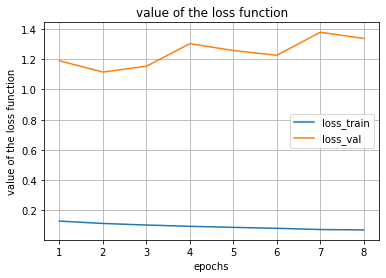

In [34]:
loss = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='loss_train')
plt.plot(epochs, loss_val, label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

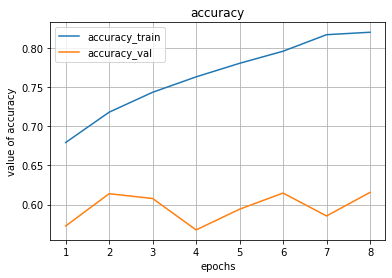

In [35]:
acc = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, label='accuracy_train')
plt.plot(epochs, acc_val, label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

## Analyse Results

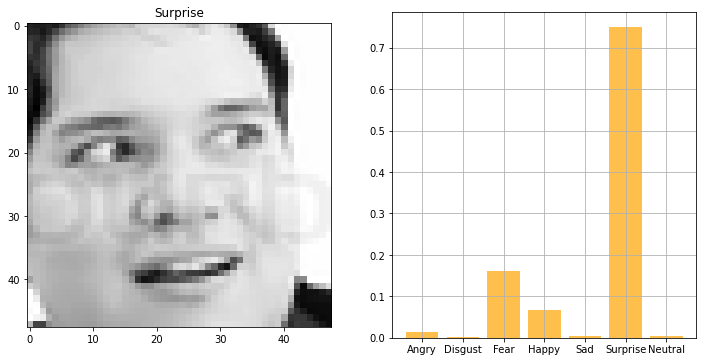

In [36]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 1500)

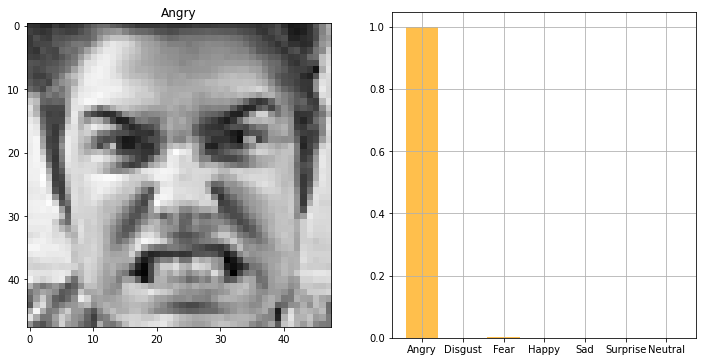

In [37]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 40)

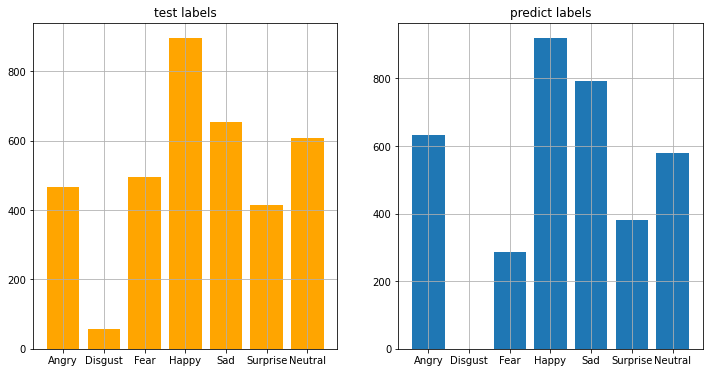

In [38]:
plot_compare_distributions(test_labels, pred_test_labels, title1='test labels', title2='predict labels')

## Analysing wrong predictions

In [39]:
df_compare = pd.DataFrame()
df_compare['real'] = test_labels.argmax(axis=1)
df_compare['pred'] = pred_test_labels.argmax(axis=1)
df_compare['wrong'] = np.where(df_compare['real']!=df_compare['pred'], 1, 0)
df_compare

,real,pred,wrong
0,0,4,1
1,1,0,1
2,4,0,1
3,6,4,1
4,3,3,0
...,...,...,...
3584,4,4,0
3585,3,3,0
3586,4,4,0
3587,4,0,1


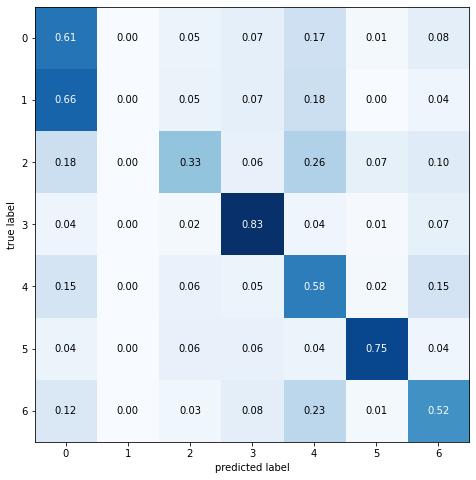

In [43]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                # class_names= emotions.value(),
                                figsize=(8, 8)
                                )
fig.show()